# First notebook on natural lenguage processing by Andrej Karpathy 
 - source makemore bigram video
 - estimation by multinomial dist
 - estimation by single layer negative log likelihood net

In [3]:
#list of names without new line
words = open("names.txt", "r").read().splitlines()

In [4]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
#creates bigrams with start end special characters 
#and count them creating a dictionary

b = {}
for w in words:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [8]:
#sort using the temporaneous function lambda using the values of the dict
#; is to suppress the print output
sorted(b.items(), key = lambda kv: -kv[1]);

In [9]:
import torch

In [10]:
N = torch.zeros((27,27), dtype=torch.int32)

In [11]:
#the alphabet and its map with integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."]=0
itos = {i:s for s,i in stoi.items()}

In [13]:
#populate the matrix counting the bigrams
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2] +=1

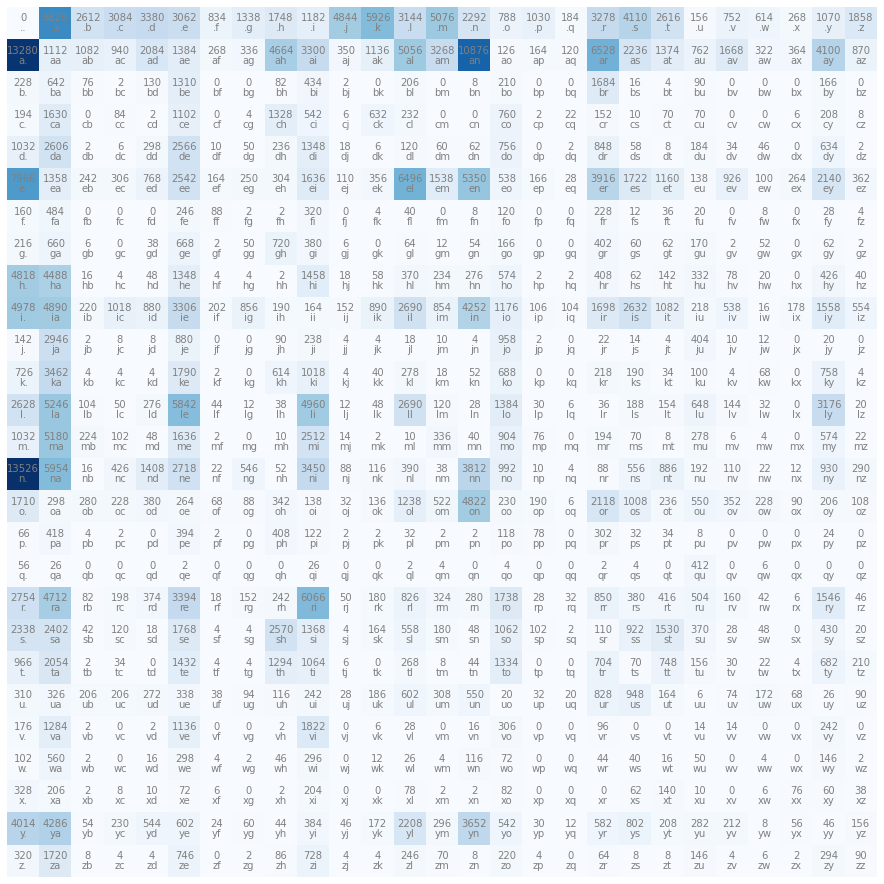

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="top", color='gray')
        plt.text(j, i, N[i,j].item(), ha="center", va="bottom", color="gray")
plt.axis("off"); 

In [15]:
#sum along 1 because prob is element divided by total along rows
g = torch.Generator().manual_seed(2147483647)
P = (N+1).float()
P /= P.sum(1, keepdims=True)


#why sum along rows and columns give the same result?

In [16]:
#a=0
#for i in range(N.shape[0]):
#    a += (N[0,i]+1)
#    #print(a, N[0,i].item(), N[i,0].item())
#    
#A, B = 0,0
#P = (N+1).float()
#A = P/P.sum(1, keepdims=True)
#B = P/P.sum(0, keepdims=True)
#A==B
##my game

In [18]:
#sampling from the distribution
for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

odaren.
iaddash.
h.
jhinatien.
egushl.


# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
- equivalent to maximizing the log likelihood (because log is monotonic)
- equivalent to minimizing the negative log likelihood
- equivalent to minimizing the average negative log likelihood

## oss

 log(a*b*c) = log(a) + log(b) + log(c)
 log(a*b*c) = log(a) + log(b) + log(c)  
 ll=a*b*c...

The likelihood of a dataset is the probability assigned by the model on that dataset. 
essentially which is the prob of anna given the bigram modelling of the dataset? it's the likelihood
This can be expressed as a product of likelihood of data points assuming independence.

In [136]:
#calculate the loglikelihood for the dataset given his pdf
#when I say max ll is because I want that those words need to have the max ll given the p dist of the data 

log_likelihood = 0.0
n = 0

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1,ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n +=1
        
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')        

#this is how much is probable our dataset given 
#such prob distribution retieved from databigrams


log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


In [142]:
#dataset generation
xs, ys = [], []

for w in words[:]:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

In [143]:
#weights matrix
W = torch.randn((27, 27), generator=g, requires_grad=True)
out = xenc @ W
out.shape

torch.Size([228146, 27])

Note that the weights with values in (-inf, +inf) are interpreted as log-counts which are then exponentiated to get units of count that have values in (0, +inf). These values are normalized to get an output vector with values in (0, 1) which we interpret as a probability distribution. This is actually just taking the softmax of the row of weights. Training the network will make these interpretations valid.

## Regularization
Observe that smoothing the count matrix approximates to it having constant entries. In the context of the neural net model, this means having a zero weight matrix so that the resulting count matrix W.exp() is a matrix of ones. So the more getting zero weights is incentivized in the loss function, the more uniform the resulting distribution is. This is precisely weight regularization. For example, we can add 
 
$\frac{α}{n}‖W‖^{2}_2$ where n=|W| to the loss function:

$$loss += 0.1 * model.W.square().mean()$$

This acts like a force that pushes the weights to zero whenever its magnitude increases to try to reduce the NLL loss.

In [151]:
#optimization
import torch.nn.functional as F

for t in range(100):
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W 
    #I'm summing for every letter(rows of xenc) the probability that
    #that letter is followed by all the other letters(columns of W)
    # log(a*b*c) = log(a) + log(b) + log(c) oss ll=a*b*c...
    # we are doing the opposite of this procedure in fact then there is an exp to obtain N
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num),ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())
    
    W.grad = None
    loss.backward()
    
    W.data += -50 * W.grad

2.4894216060638428
2.4892659187316895
2.4891140460968018
2.4889650344848633
2.4888205528259277
2.4886786937713623
2.4885404109954834
2.488405704498291
2.4882733821868896
2.488144636154175
2.48801851272583
2.4878954887390137
2.4877750873565674
2.4876575469970703
2.4875423908233643
2.4874298572540283
2.4873199462890625
2.4872121810913086
2.4871068000793457
2.487003803253174
2.4869027137756348
2.4868040084838867
2.4867074489593506
2.4866127967834473
2.486520528793335
2.486429452896118
2.4863409996032715
2.4862539768218994
2.486168146133423
2.4860851764678955
2.4860031604766846
2.4859228134155273
2.485844135284424
2.485767126083374
2.485691547393799
2.4856173992156982
2.485544443130493
2.485473394393921
2.4854037761688232
2.485335111618042
2.4852678775787354
2.485201597213745
2.4851372241973877
2.4850735664367676
2.485011100769043
2.484950065612793
2.4848899841308594
2.4848310947418213
2.4847731590270996
2.4847166538238525
2.4846603870391846
2.4846057891845703
2.4845516681671143
2.48449873

In [166]:
#sampling from net
for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator = g).item()
        if ix == 0:
            break
        out.append(itos[ix])
        
    print("".join(out))
    

amerixay
cetchaabeshetth
ce
amalavan
todan
